In [19]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breast-histopathology-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F7415%2F10564%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240925%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240925T144325Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D813d49dbde571546715d3624272ff1cb13e3bb911c8d0530e37bc4b7ce03487a0adf654da70099054b3068f738ae0a24d0bbfc4a48c7589b927f29c4f5b0391349a5df1e8d361bbf0adaab5712e2e8fe52a4f44c8304fb71bbfcfa91c9e570344705ef5ab6efcab0a0d643513eb09fb209c6399e041aefb87d7b723ff011908533872328f17f083a8595ce4e6e6841f7eb9efbc9071b5300b403a4bfc320900298c0cd75f0a1ecfe54ce8b0aedcca18d975d7d00f18164f830bae0ec94677211774a14f9db1c2d84b12068206435be1b000716ba325fc59fbdd1d40319e403266ebf8232b103161161feb91ffebf02feb1513fffde84ca7509dbf01b2d380970'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3326820824 bytes downloaded
Downloaded and uncompressed: breast-histopathology-images
Data source import complete.


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers

In [21]:
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/12817/0/12817_idx5_x2901_y801_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/12817/0/12817_idx5_x451_y701_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/12817/0/12817_idx5_x2301_y151_class0.png


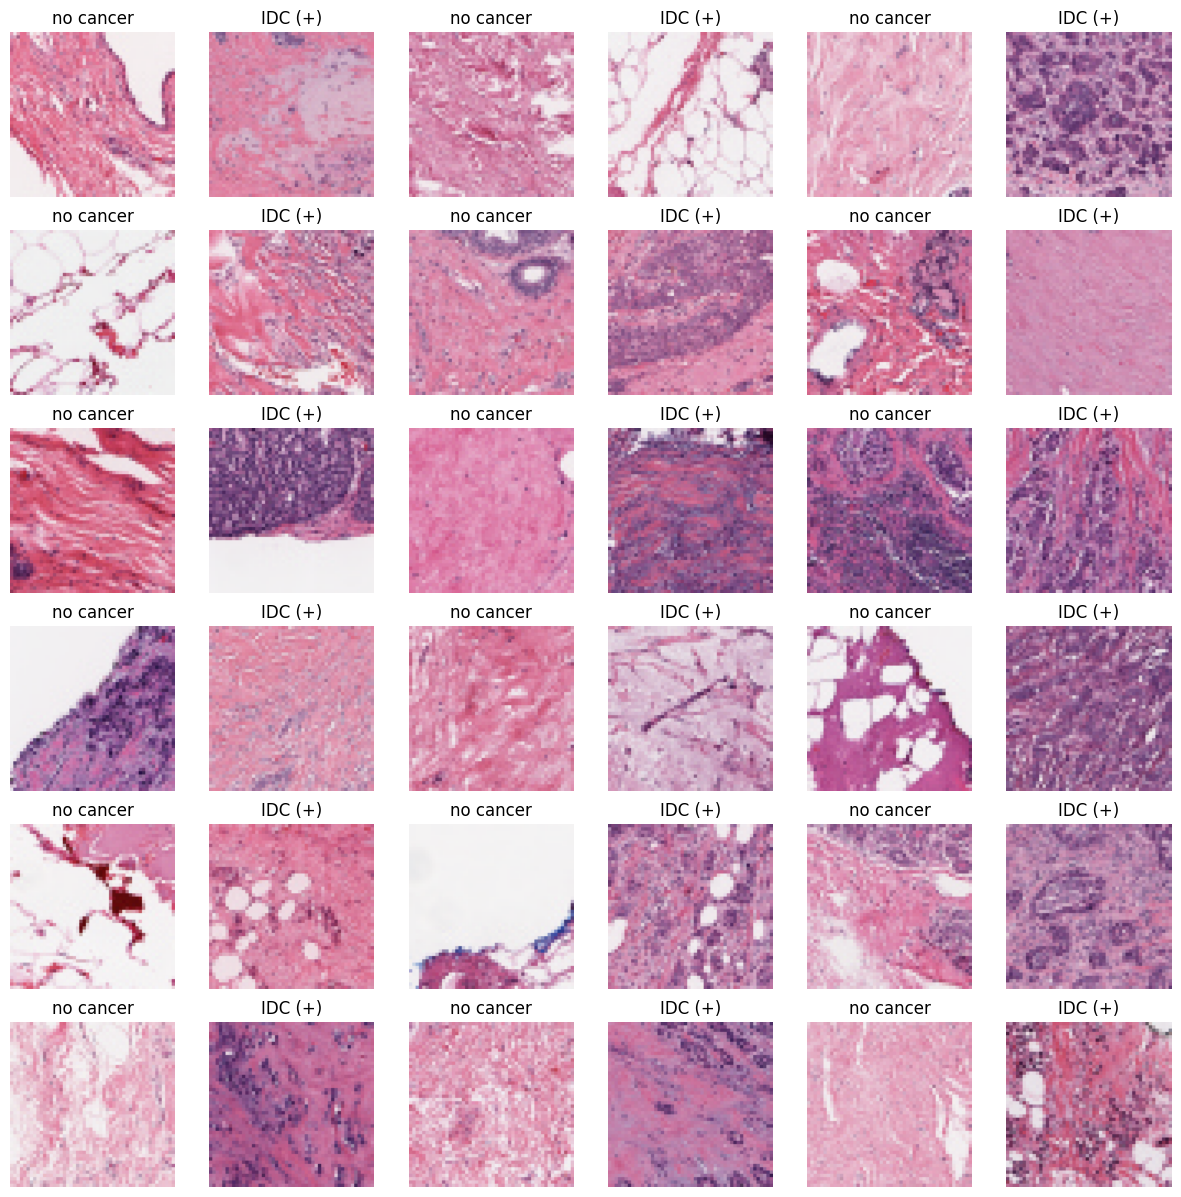

In [23]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)

    elif img[-5] == '1' :
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:

        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:

        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s)
        plt.axis('off')
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1


In [24]:
NewN_IDC=N_IDC[:78786]
print(len(NewN_IDC))
print(len(P_IDC))

78786
78786


In [25]:
non_img_arr = []
can_img_arr = []

for img in NewN_IDC:
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])


In [26]:
print(len(non_img_arr))
print(len(can_img_arr))
print(len(non_img_arr)+len(can_img_arr))

78786
78786
157572


In [28]:
X = []
y = []

# Convert non_img_arr and can_img_arr to NumPy arrays with a consistent shape
non_img_arr = np.array(non_img_arr, dtype=object)
can_img_arr = np.array(can_img_arr, dtype=object)

breast_img_arr = np.concatenate((non_img_arr[:12389], can_img_arr[:12389]))
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [29]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)


Total number of images: 24778
Number of IDC(-) Images: 21030
Number of IDC(+) Images: 3748
Image shape (Width, Height, Channels): (50, 50, 3)


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (17344, 50, 50, 3)
Testing Data Shape: (7434, 50, 50, 3)


In [31]:
img_size = (50, 50) # Corrected the typo from img_simg_sizeize to img_size
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 2 # to define number of classes in dense layer
from tensorflow.keras.regularizers import l2
# create pre-trained model
base_model = tf.keras.applications.EfficientNetV2S(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
early_stop = EarlyStopping(monitor='val_loss', patience=6) #Early Stopping
tf.keras.regularizers.l2(0.01)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.01)))
model.add(Dense(2, activation='softmax'))

model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 50, 50, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 50, 50, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 25, 25, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 25, 25, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 25, 25, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,514,410 (9.59 MB)

 Trainable params: 2,513,642 (9.59 MB)

 Non-trainable params: 768 (3.00 KB)

In [32]:
model.compile(Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 60, batch_size = 35)

Epoch 1/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8086 - loss: 5.9658 - val_accuracy: 0.8816 - val_loss: 5.4618
Epoch 2/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8880 - loss: 5.3655 - val_accuracy: 0.8742 - val_loss: 5.0444
Epoch 3/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8925 - loss: 4.9175 - val_accuracy: 0.8667 - val_loss: 4.6149
Epoch 4/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8995 - loss: 4.4475 - val_accuracy: 0.8655 - val_loss: 4.1624
Epoch 5/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8999 - loss: 3.9919 - val_accuracy: 0.8772 - val_loss: 3.7360
Epoch 6/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8999 - loss: 3.5774 - val_accuracy: 0.8476 - val_loss: 3.4061
Epoch 7/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9061 - loss: 3.1822 - val_accuracy: 0.8458 - val_loss: 3.0483
Epoch 8/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9082 - loss: 2.8262 - val_

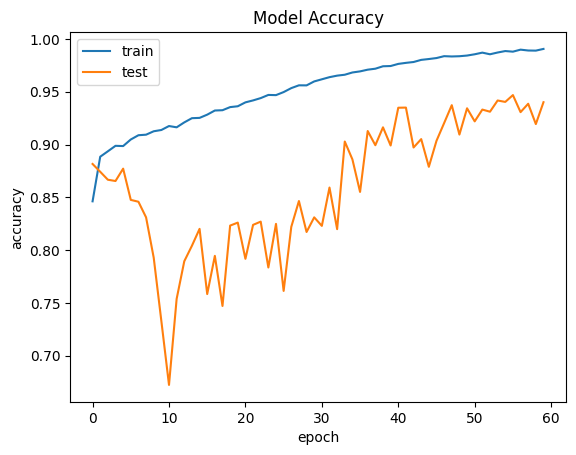

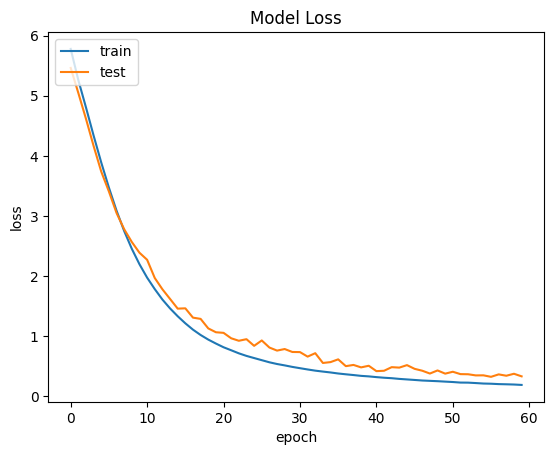

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


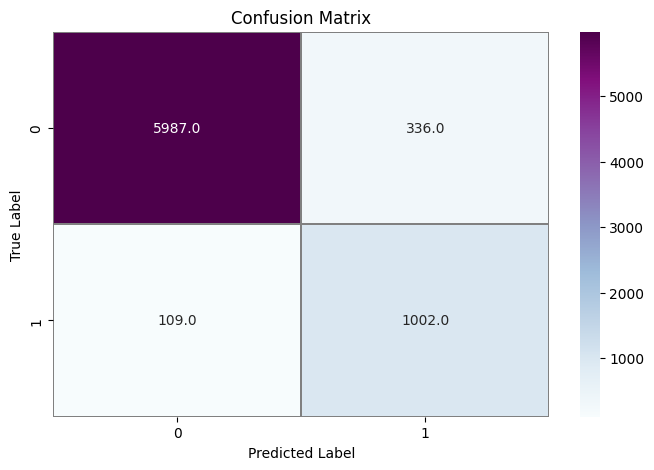

In [34]:
from sklearn.metrics import accuracy_score
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(Y_test,axis = 1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

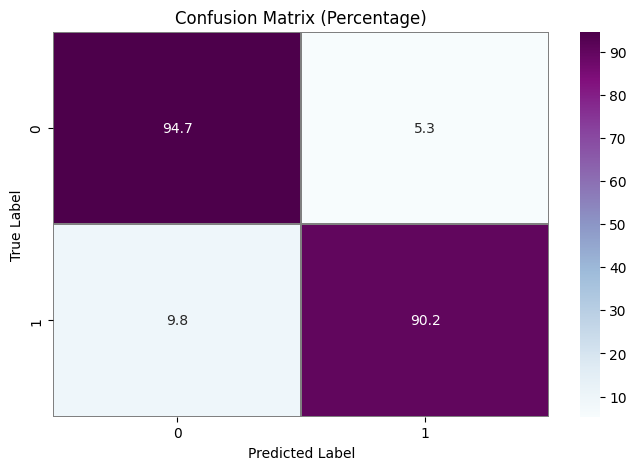

In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix
#Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

In [36]:
model.evaluate(X_test,Y_test)

233/233 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9422 - loss: 0.3309


[0.33113500475883484, 0.940139889717102]

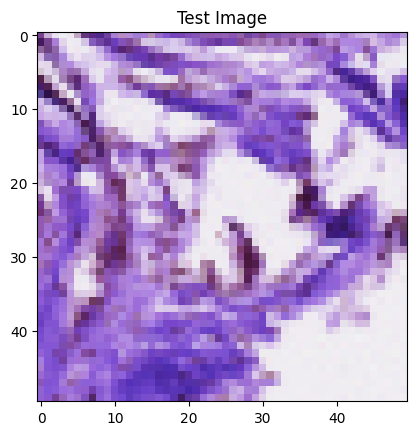

In [37]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])

index = 1000
img_plot(X_test, index)

In [38]:
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])
index = 4000
input = X_test[index:index+1]
pred = model.predict(input)[0].argmax()
label = Y_test[index].argmax()
print('Predicted Value using  cnn model',pred)
print("True Value",label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
Predicted Value using  cnn model 0
True Value 1


In [41]:
#model.save("/kaggle/working/Brest breast_cancer_detection.keras")